### IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')
plt.style.use('seaborn-darkgrid')


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import gzip

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
# amz_home_n_kitch = pd.read_json('Data/Home_and_Kitchen_5.json')

In [3]:
path = 'Data/reviews_Home_and_Kitchen_5.json.gz'

In [4]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF(path)

### DATA CLEANING / EDA

In [5]:
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"


In [6]:
df.shape

(551682, 9)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551682 entries, 0 to 551681
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      551682 non-null  object 
 1   asin            551682 non-null  object 
 2   reviewerName    546729 non-null  object 
 3   helpful         551682 non-null  object 
 4   reviewText      551682 non-null  object 
 5   overall         551682 non-null  float64
 6   summary         551682 non-null  object 
 7   unixReviewTime  551682 non-null  int64  
 8   reviewTime      551682 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 42.1+ MB


In [8]:
df.drop(columns=['helpful']).duplicated().sum()

0

In [9]:
df.isnull().sum()

reviewerID           0
asin                 0
reviewerName      4953
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

In [10]:
# Converting 'unixReviewTime' column to a datetime type, and renaming column
df['reviewDate'] = pd.to_datetime(df['unixReviewTime'], unit='s')

# Dropping 'unixReviewTime' and 'reviewTime' columns -- no longer necessary
df.drop(columns=['unixReviewTime', 'reviewTime'], inplace=True)

In [11]:
df.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,reviewDate
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,2013-10-19


##### Creating target ('ratio' >= 0.7) column 

In [12]:
# unpacking the list values in 'helpful' column into their own separate columns
helpfulness_df = pd.DataFrame(df['helpful'].tolist(), columns=['upvotes', 'total_votes'])

# adding new columns to dataframe
df = pd.concat([df, helpfulness_df], axis=1)

# fxn to get ratio of upvotes over total votes
def get_vote_ratio(row):
    try:
        return row['upvotes']/row['total_votes']
    except ZeroDivisionError:
        return 0

# creating new column with ratio values
df['ratio'] = df.apply(get_vote_ratio, axis=1)

# Setting classification threshold for 'helpful' at 70% of upvotes/total votes (1 = helpful, 0 = unhelpful)
df['target'] = (df['ratio'] >= 0.7).astype(int)

In [13]:
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,2013-10-19,0,0,0.000000,0
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,2014-06-18,0,0,0.000000,0
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",2013-05-05,26,27,0.962963,1


In [14]:
# Dropping 'helpful' column
df.drop(columns='helpful', inplace=True)

In [15]:
df.head(1)

,reviewerID,asin,reviewerName,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target
0,APYOBQE6M18AA,0615391206,Martin Schwartz,My daughter wanted this book and the price on ...,5.0,Best Price,2013-10-19,0,0,0.0,0


In [16]:
print(df['target'].value_counts(normalize=True))
print('')
print(df['overall'].value_counts(normalize=True).sort_index())

0    0.654297
1    0.345703
Name: target, dtype: float64

1.0    0.049133
2.0    0.044071
3.0    0.081676
4.0    0.191248
5.0    0.633872
Name: overall, dtype: float64


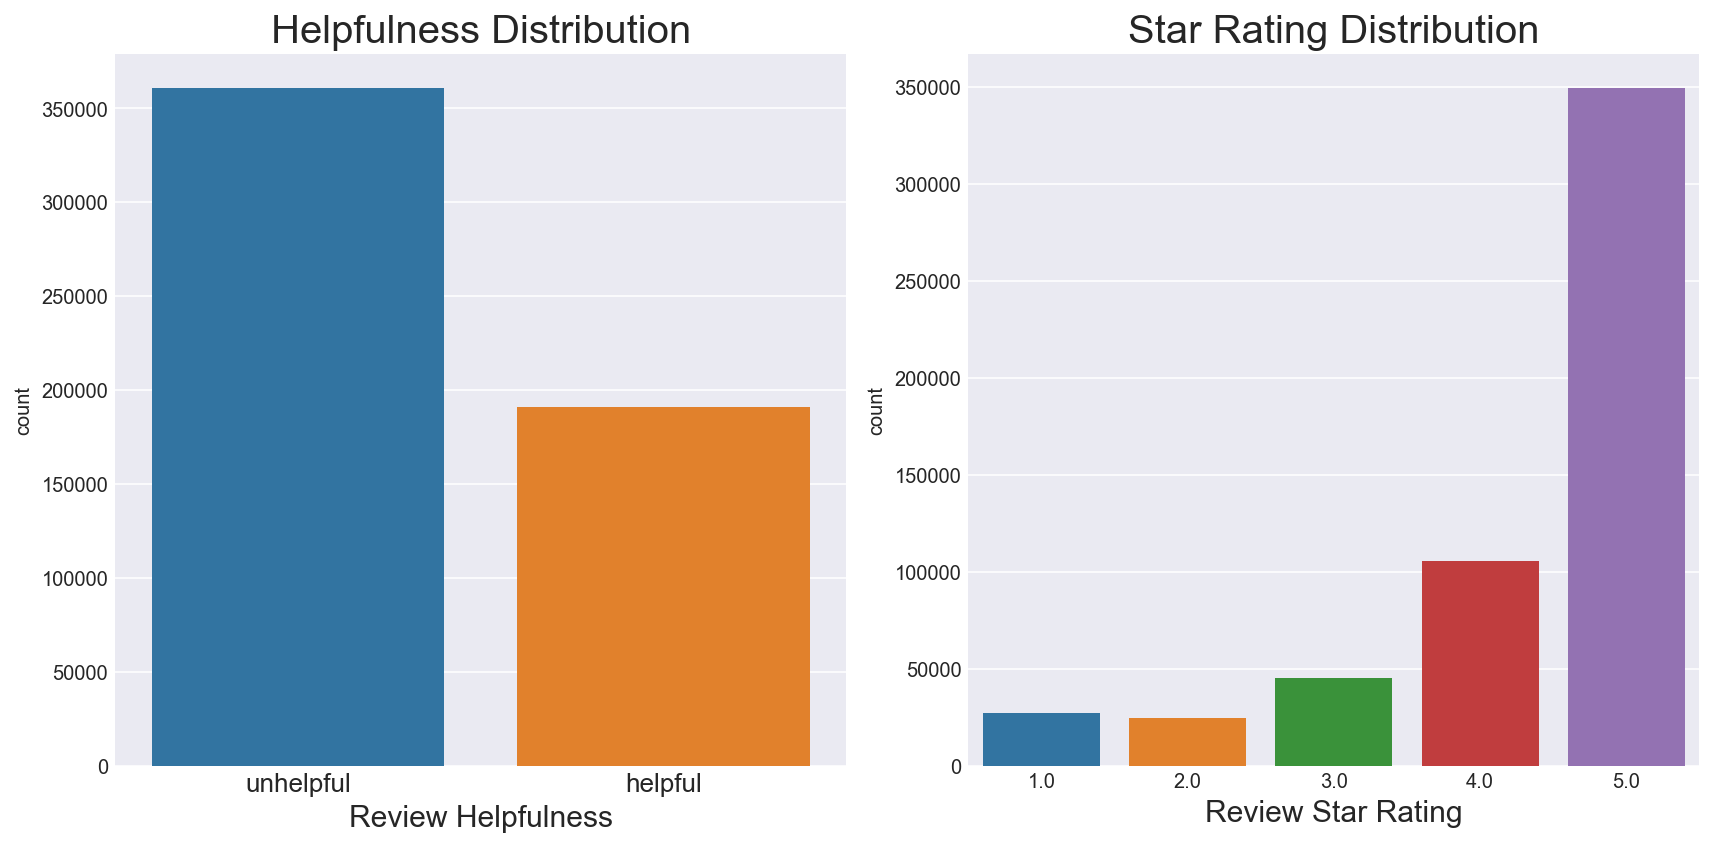

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.countplot(x=df['overall'], ax=ax2)
ax2.set_xlabel('Review Star Rating', size=15)
ax2.set_title('Star Rating Distribution', size=20)

sns.countplot(x=df['target'], ax=ax1, )
ax1.set_xticklabels(labels=['unhelpful', 'helpful'], size=13)
ax1.set_xlabel('Review Helpfulness', size=15)
ax1.set_title('Helpfulness Distribution', size=20)

fig.tight_layout();

##### Creating new votes_df dataframe, which drops all rows where there are no votes for 'helpful' column.

In [18]:
votes_df = df.copy()

votes_df.drop(votes_df[votes_df['total_votes']== 0].index, inplace=True)

# Resetting index after dropping rows
votes_df.reset_index(drop=True, inplace=True)

print(votes_df.shape)

(248634, 11)


In [19]:
print(votes_df['target'].value_counts(normalize=True).sort_index())
print('')
print(votes_df['overall'].value_counts(normalize=True).sort_index())

0    0.232937
1    0.767063
Name: target, dtype: float64

1.0    0.080701
2.0    0.060076
3.0    0.098020
4.0    0.192399
5.0    0.568804
Name: overall, dtype: float64


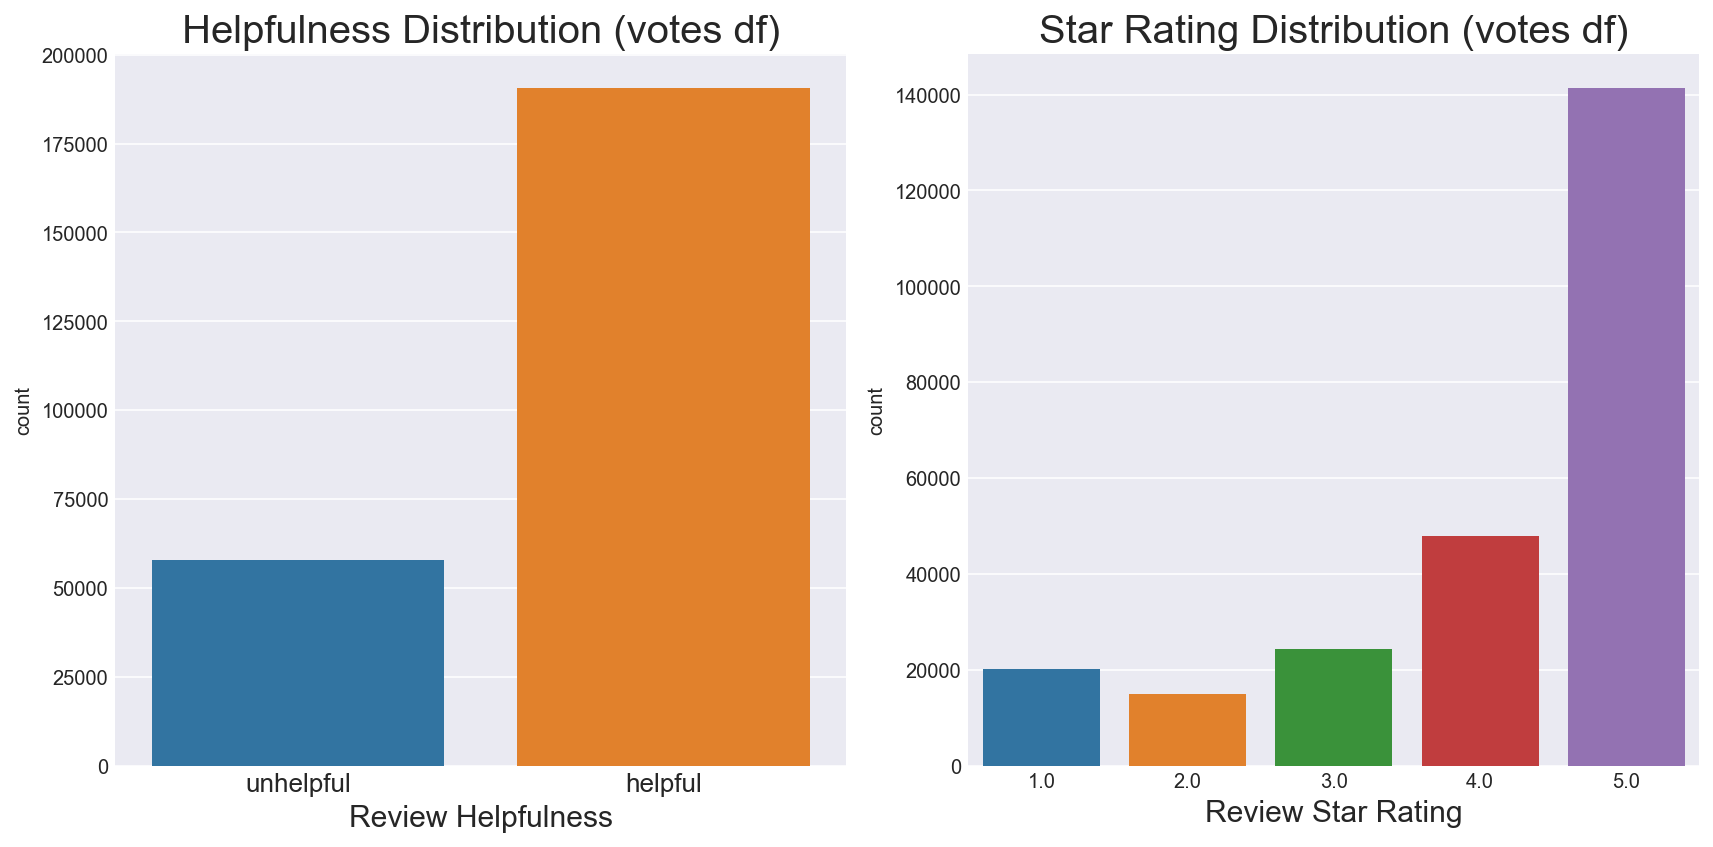

In [20]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.countplot(x=votes_df['overall'], ax=ax2)
ax2.set_xlabel('Review Star Rating', size=15)
ax2.set_title('Star Rating Distribution (votes df)', size=20)

sns.countplot(x=votes_df['target'], ax=ax1, )
ax1.set_xticklabels(labels=['unhelpful', 'helpful'], size=13)
ax1.set_xlabel('Review Helpfulness', size=15)
ax1.set_title('Helpfulness Distribution (votes df)', size=20)

fig.tight_layout();

In [21]:
pd.DataFrame(df.groupby(by=['overall'])['target'].value_counts(normalize=True))

target
overall target          
1.0     0       0.572567
        1       0.427433
2.0     0       0.636614
        1       0.363386
3.0     0       0.653366
        1       0.346634
4.0     0       0.645667
        1       0.354333
5.0     0       0.664586
        1       0.335414

In [22]:
pd.DataFrame(votes_df.groupby(by=['overall'])['target'].value_counts(normalize=True).sort_index())

target
overall target          
1.0     0       0.422577
        1       0.577423
2.0     0       0.408516
        1       0.591484
3.0     0       0.359115
        1       0.640885
4.0     0       0.218492
        1       0.781508
5.0     0       0.170629
        1       0.829371

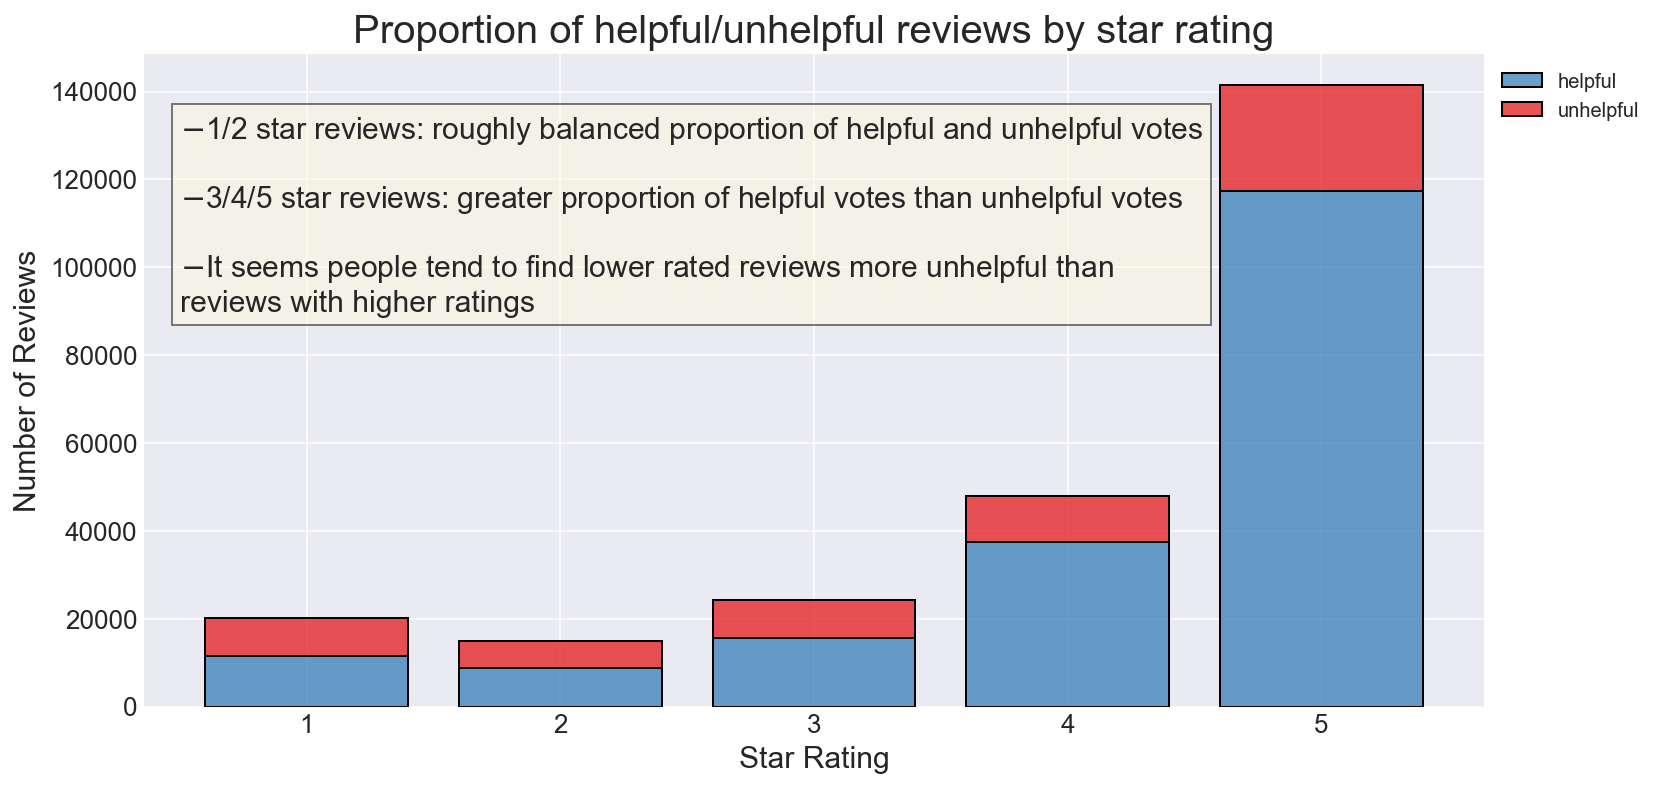

In [36]:
plt.figure(figsize=(12,6))
sns.histplot(data=votes_df, x='overall', stat='count', hue='target',
             multiple='stack', palette='Set1', discrete=True, shrink=.8) #palette='husl', multiple='dodge', 'FILL'

plt.title('Proportion of helpful/unhelpful reviews by star rating', size=20)
plt.xticks(ticks=votes_df['overall'].unique(), size=13)
plt.yticks(size=13)
plt.ylabel('Number of Reviews', size=15)
plt.xlabel('Star Rating', size=15)

plt.text(0.5, 90_000,
         '$-$1/2 star reviews: roughly balanced proportion of helpful and unhelpful votes\n\n$-$3/4/5 star reviews: greater proportion of helpful votes than unhelpful votes\n\n$-$It seems people tend to find lower rated reviews more unhelpful than\nreviews with higher ratings',
         fontsize=15, 
         bbox = dict(facecolor='cornsilk', alpha=0.5)
        )

plt.legend(labels=(['helpful', 'unhelpful']), loc='upper left', bbox_to_anchor=(1,1), ncol=1);

test test

##### Creating reviewText word count column

In [48]:
def word_count(review):
    return len(review.split())

votes_df['review_word_count'] = votes_df['reviewText'].map(word_count)

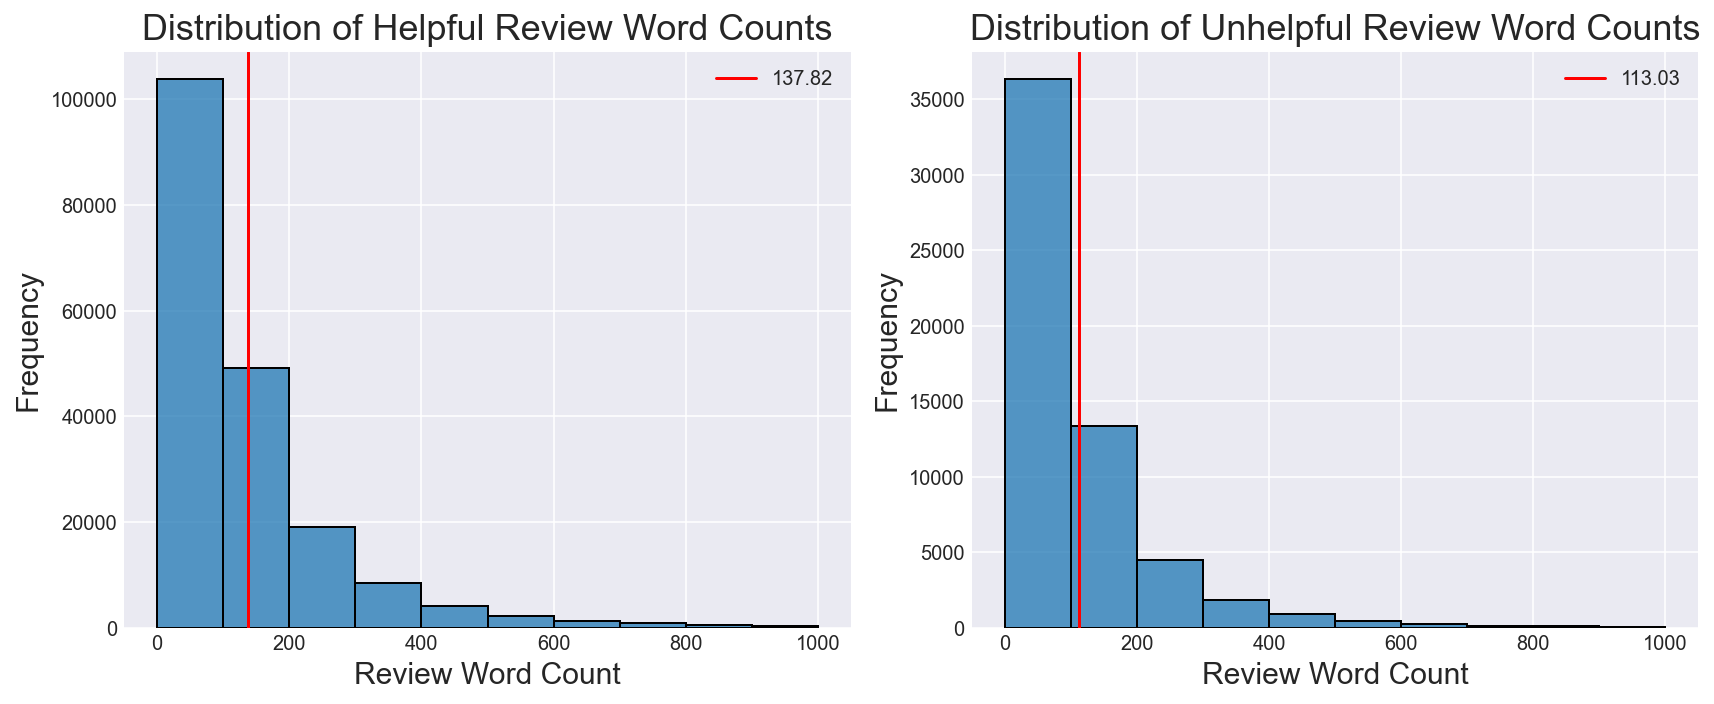

In [92]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

sns.histplot(votes_df[votes_df['target'] == 1]['review_word_count'],
         bins=[0,100,200,300,400,500,600,700,800,900,1000],
        ax=ax1)
ax1.axvline(votes_df[votes_df['target'] == 1]['review_word_count'].mean(), color='red',
           label=str(np.round(votes_df[votes_df['target'] == 1]['review_word_count'].mean(),
                             decimals=2)))
ax1.set_title('Distribution of Helpful Review Word Counts', size=18)
ax1.set_xlabel('Review Word Count', size=15)
ax1.set_ylabel('Frequency', size=15)
ax1.legend()

sns.histplot(votes_df[votes_df['target'] == 0]['review_word_count'],
         bins=[0,100,200,300,400,500,600,700,800,900,1000],
        ax=ax2)
ax2.axvline(votes_df[votes_df['target'] == 0]['review_word_count'].mean(), color='red',
           label=str(np.round(votes_df[votes_df['target'] == 0]['review_word_count'].mean(),
                             decimals=2)))
ax2.set_title('Distribution of Unhelpful Review Word Counts', size=18)
ax2.set_xlabel('Review Word Count', size=15)
ax2.set_ylabel('Frequency', size=15)
ax2.legend()

fig.tight_layout();

Helpful reviews are a little more wordy than unhelpful reviews on average. The average number of words in a helpful review is 137.82, compared to an average of 113.03 words in an unhelpful review.

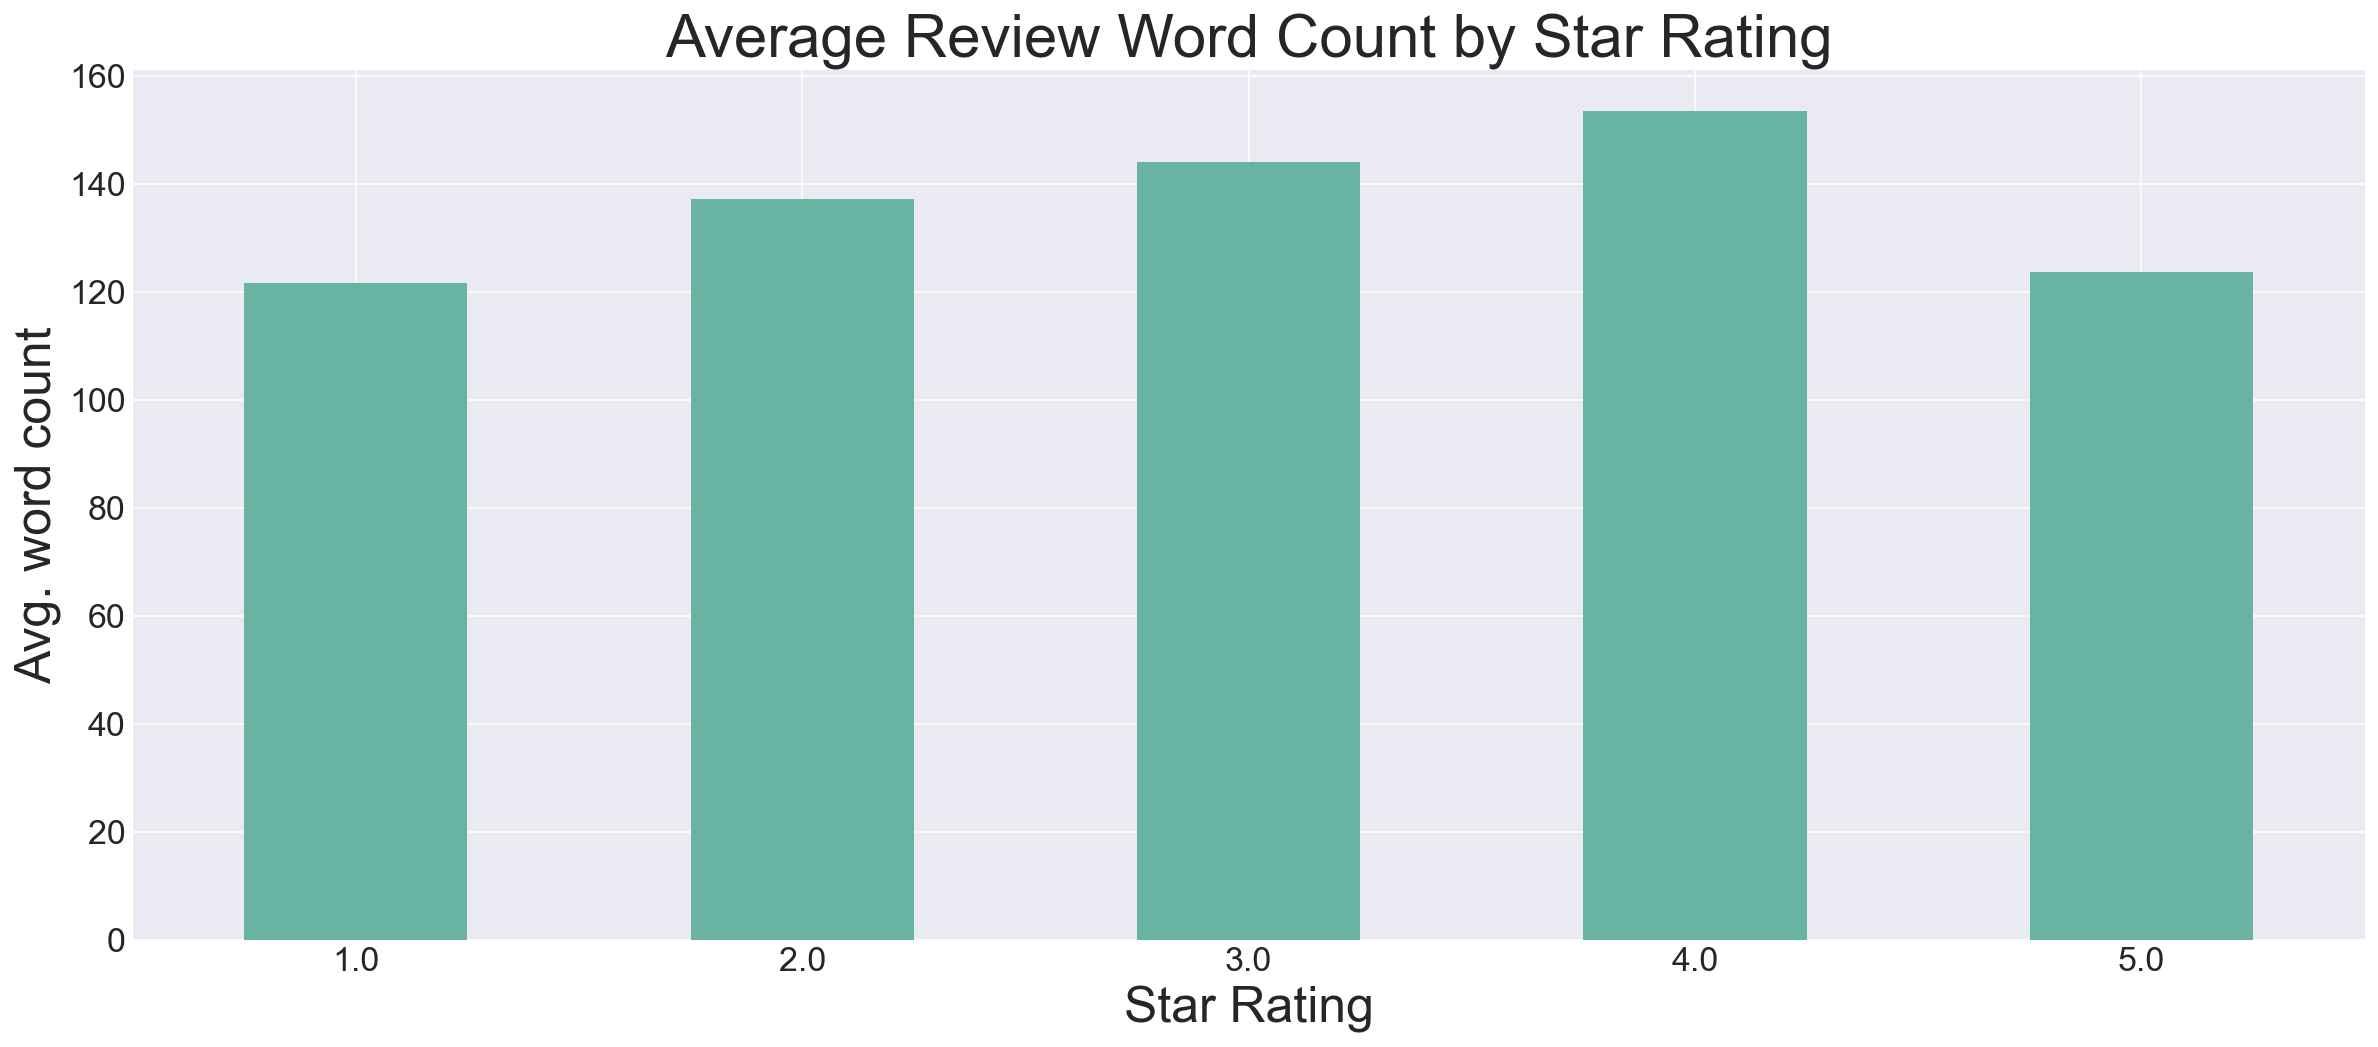

In [90]:
plt.figure(figsize=(20, 8))
votes_df.groupby('overall').mean()['review_word_count'].plot(kind='bar', color='#69b3a2')

plt.title('Average Review Word Count by Star Rating', size=30)
plt.xticks(rotation=360, size=17)
plt.yticks(size=17)
plt.ylabel('Avg. word count', size=25)
plt.xlabel('Star Rating', size=25);

1 and 5 star reviews are on the lower end of the average word count, hovering just above 120 words per review. 2, 3, and 4 star reviews all average above 130 words per review, with 4 star reviews having the highest average word count at a little over 150 words per review.

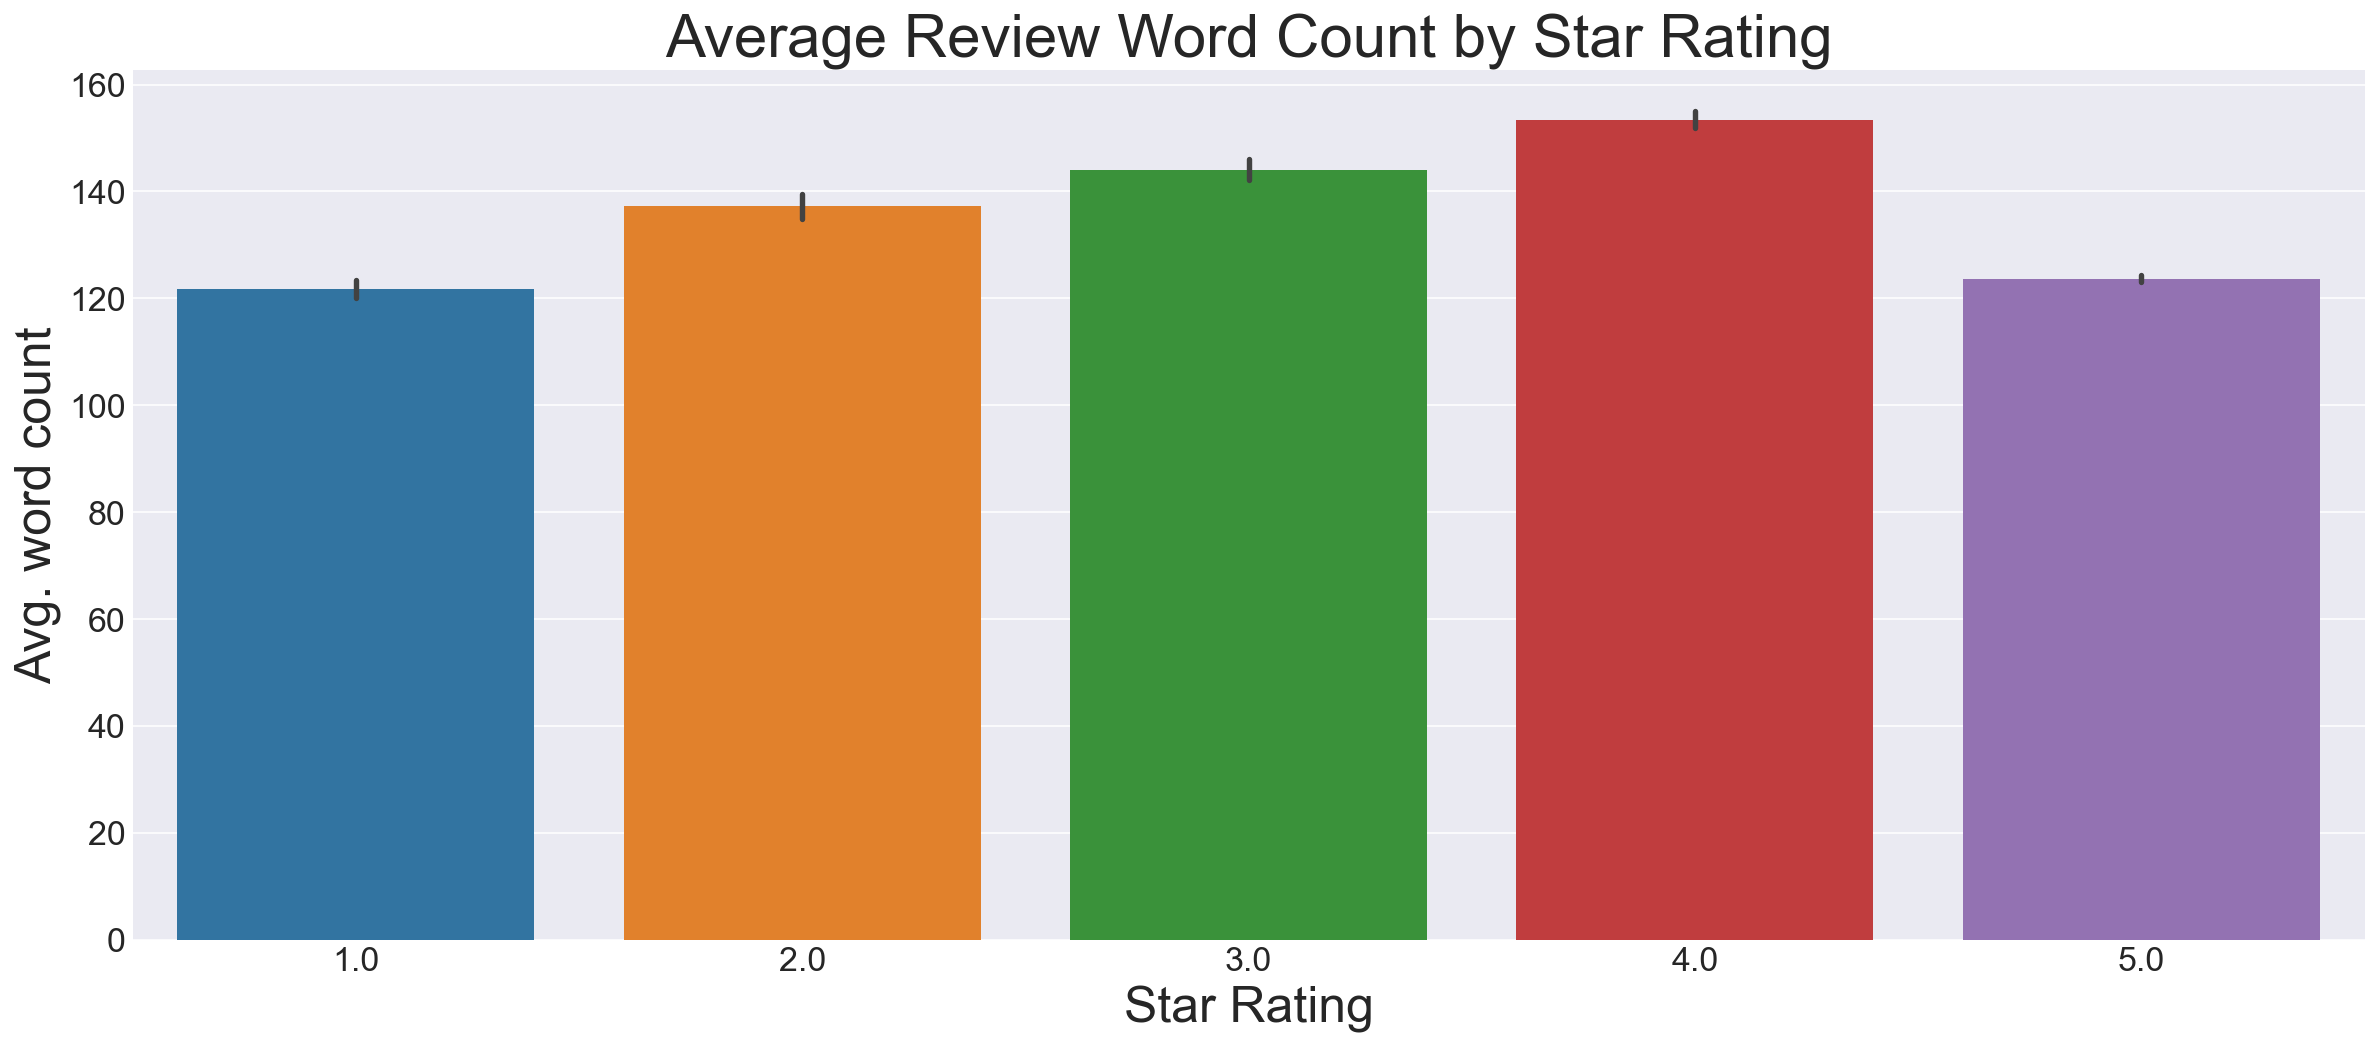

In [89]:
plt.figure(figsize=(20, 8))
sns.barplot(x=votes_df['overall'], y=votes_df['review_word_count'])

plt.title('Average Review Word Count by Star Rating', size=30)
plt.xticks(rotation=360, size=17)
plt.yticks(size=17)
plt.ylabel('Avg. word count', size=25)
plt.xlabel('Star Rating', size=25);

### NLP PRE-PROCESSING

In [24]:
votes_df['reviewText'].iloc[156987]

'My mother-in-law is up in age and these are great to create dinners for her to justpop in the microwave.  She loves them.'

search for reviews that contain "in exchange for my honest review" or some sort of combo of those words to see if there is a trend with their star ratings or hlpful votes. 'honest review' might probs be kew word. I suspect there will be a high number of 4/5 star ratings.

In [93]:
# votes_df[votes_df['reviewerName'].isna() == True]

may want to impute NaNs with something like 'user X' if going to run through a model that doesn't handle NaNs well. ALternatively coudl also just omit that column when running model.

Feature engineering: add downvotes column, merge metadata dataset to this dataset on asin, to retrieve product names, add target column, seaprate from ratio column, add word length columns for review text and maybe summary (like in the reddit project), -- THIS IS ALL ACTUALLY JUST EDA STUFF TO SEE TRENDS THAT IS NOT NECESSARILY NEEDED FOR MODEL, UT TOPLOT NICE GRAPHS SHOWING TRENDS.

In [26]:
votes_df['reviewText'].iloc[1784]

"well i like my women with meat on, not too much, not too little. this thing is just a tad on the skinny model side of life. so i am not too sure of it's life-span. from the heft and feel. maybe a few years. my old one was ok, but while on the downhill side of life, a big handle is of value (torque is good), so tis is a replacement. the old one is still alive and sharp and does a bang up job, save the torque thing. now i am ok with miss runway, but like a glamour gal she is on the pricey side...oh i'd say 8-9bucks would be a real deal. 15, well i am not shouting out in glee 'look how much i paid'."

In [27]:
votes_df['reviewText'].iloc[112]

'A time for every seasoning......and a utensil for every purpose. The Cuisinart Mini Prep does not serve well as a primary processor for heavy jobs. That was not its intended design, or function.I obtained my first mini prep as a promotional gift with a DLC-7 purchase. For many years they have been contributing to my cooking enjoyment as a problem-free, complimentary team in a busy kitchen. When their lexan lids eventually chipped, (which admittedly is a major cause of aggravation with Cuisinart\'s products) I opted to replace them rather than spend up to 50% of their new cost for replacement bowls. I upgraded the old DLC-7 that is still mechanically perfect, with a MP-14 TM Limited Edition.The Mini Prep perfectly compliments larger processors. I specifically elected to stay with Cuisinart\'s older, boxier design; because its function is favored over the newer, sleeker model, the DLC-2ABC.The mini prep makes delectable, creamy homemade sauces and dressings. It performs equally well mak

In [28]:
votes_df['reviewText'].iloc[165]

'I asked my husband to buy this machine for me for Christmas instead of jewelry, and have no regrets!  I love all the sorbets, ice milks and ice creams that we can make.  It is simple to use, and the results taste great!My only complaint is how loud the machine is.  I can\'t really let the machine run while we are having dinner unless I put the ice cream maker far away from the kitchen and dining room.  But other than that inconvenience, I can\'t complain.I would agree with the other reviewers -- use cold ingredients, and start your ice cream as soon as you take the bowl out of the freezer.  I let my bowl freeze for at least two days before using it.  I put it in a plastic bag, and then put a zip-loc bag of ice in the container just to be sure.I have a hard time using all of the egg yolks and heavy cream to make true "ice cream" (although a splurge once in awhile isn\'t a bad thing!).  I try to stick to the lower fat recipes.  You can find endless recipes and ideas on the internet.  I 

In [31]:
votes_df['reviewText'].iloc[248070]

'Spent many hours researching how to install a whole house humidifier and this one was recommended many times. When our furnace got serviced this fall the technician also recommended we get a humidifier and when I asked him which model this is the one he recommended. It\'s really hard to find anyone selling this unit because the manufacturer doesn\'t want just anyone to install it, they recommend a technician so I was pretty happy when I found it here on Amazon.After doing some research and a couple times watching this video on youtube([...]) I decided to take the project on myself. It actually was a lot easier than I had expected. Aprilaire\'s instructions were pretty easy to follow and the automatic digital control gives you a great display in case an error code comes up.If you are good at following instructions, and have some confidence you can save yourself around $300-$500 on the installation cost I was quoted from 4 different HVAC companies. I was able to complete the project in 

In [29]:
votes_df[votes_df['total_votes'] > 50]

,reviewerID,asin,reviewerName,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target
21,A1MMOO9F6U6JQN,0912696591,"David Kahle ""Super Chef""",I bought this book to help me out with decorat...,5.0,Wilton Decorating Basics Lesson Plan,2011-01-31,62,64,0.968750,1
87,A1Z54EM24Y40LL,B00000JGRP,csm,I've had this machine for about 10 years now a...,4.0,A Great Little Machine,2005-05-09,47,52,0.903846,1
112,A37CKQPJ6CJED2,B00000JGRP,Southern Review,A time for every seasoning......and a utensil ...,5.0,A time for every seasoning......,2004-09-28,284,294,0.965986,1
113,A2806I45H42REF,B00000JGRP,Spyce,I have been using the Mini-Prep for a few year...,5.0,Mini-Prep,2006-10-20,125,127,0.984252,1
165,A26PEAFQULPQ3F,B00000JGRT,"B. Pfahnl ""bpfahnl""",I asked my husband to buy this machine for me ...,5.0,Easy to use and makes GREAT product!,2002-02-07,560,604,0.927152,1
...,...,...,...,...,...,...,...,...,...,...,...
247308,A1DQHS7MOVYYYA,B00JFLVMNE,A. Boston,"I've been a ninja lover from the beginning, pu...",4.0,Compared to to the Ninja Pulse,2014-05-21,40,52,0.769231,1
247326,A2FFWYG9YYZFA5,B00JFLVMNE,She,The Ninja blender's design is flawed. I was t...,1.0,Impractical design,2014-06-08,34,63,0.539683,0
248019,A2263T18M22S9T,B00K70QDJA,William Brown,This product is not designed to run longer tha...,5.0,Legit!,2010-05-24,196,204,0.960784,1
248070,A15GKMFE0D5Q5R,B00K8FPSSG,M. Jourdan,Spent many hours researching how to install a ...,5.0,Exactly what the house needed with a new baby ...,2011-11-16,195,198,0.984848,1


In [32]:
votes_df[(votes_df['total_votes'] > 50) & (votes_df['overall'] < 3)]

,reviewerID,asin,reviewerName,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target
210,A3349XAKF2RWA9,B00000JGRT,"Jill Jones ""Regular Gal""","Maybe I just got a lemon, judging by all the f...",1.0,Just doesn't work,2003-12-17,68,86,0.790698,1
496,AKXWTHZQZJPW0,B00002N602,The Gadget Gourmet,I bought this exact model from Amazon in Octob...,1.0,avoid this rusty pot!,2006-02-06,129,156,0.826923,1
653,A2AYRQZTZI8MB3,B00002N8DF,"P. Pun ""mypicks""",It's does not vac at all. I am going to get a...,1.0,Waste of $$$,2003-11-14,0,66,0.000000,0
693,AHSVU6B7EADS1,B00002ND67,NeoEngineer,I went out to my local Lowe's today and bought...,1.0,"Don't believe the hype, buy it local and try i...",2008-06-19,92,112,0.821429,1
1750,AI0NMYA3LKXW1,B00004OCMB,"Bartok Kinski ""A casual stroll through the lu...","I've always found the ""Pie Server"" utensil use...",1.0,utencil useless,2010-10-11,1,96,0.010417,0
...,...,...,...,...,...,...,...,...,...,...,...
239259,A3BVEHLYG4PVCM,B00DV8ADZK,"grone ""ronnyrone""",These so called sheets are thin enough to read...,1.0,LOW QUALITY,2013-09-10,92,101,0.910891,1
240446,A1G6FPU9QO7YOT,B00EINBSEW,Dannella Pennington,"First, pillow is quite firm and thick. It is O...",1.0,SUGGEST BUYING ANOTHER BRAND IF YOU ARE CONCER...,2014-02-17,115,138,0.833333,1
243307,A2MNJ7KXOCRAXB,B00GCS37AY,amazon#1fan,Mine was not purchased from Amazon. I received...,1.0,Mine caught FIRE!! BUYER BEWARE,2014-01-23,48,58,0.827586,1
243309,A3DQWFWINN3V5A,B00GCS37AY,David A. Lessnau,I bought this Nutribullet Pro 900 from Amazon ...,1.0,"Broke After 10 Uses, Nutribullet Wouldn't Hono...",2014-01-16,284,335,0.847761,1


In [33]:
votes_df['reviewText'].iloc[243309]

'I bought this Nutribullet Pro 900 from Amazon as a Christmas present for my wife back on 07 December 2013 (sold by Speed of Light Distributors).  It was delivered quickly, but then sat under the tree, unused, until 26 December 2013.  Initially, my wife enjoyed it quite a bit.  But, on 10 January 2014, after about 10 uses, the gasket ring on one of the blade assemblies came off.  Thinking it trivial, we didn\'t think too much about that.  But, we noted that the manual specifically states that the gasket ring should not be removed and if it does come off, we should contact the company for a replacement blade assembly.  My wife confirmed that statement by asking on their Facebook page and they told her how to contact support.  She emailed support, told them the story, and gave them a copy of Amazon\'s invoice.  Today, Nutribullet emailed back and told her they wouldn\'t honor the warranty because the seller (Speed of Light) isn\'t an "authorized vendor." They told her she could buy a rep

In [40]:
votes_df[votes_df['total_votes'] == max(votes_df['total_votes'])]

,reviewerID,asin,reviewerName,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target
179990,A1TTA1UUGY4WY4,B0047E0EII,SW3K,For decades I have been trying to come up with...,5.0,"No more winning for you, Mr. Banana!",2011-03-03,52176,52861,0.987041,1


In [41]:
votes_df['reviewText'].iloc[179990]

'For decades I have been trying to come up with an ideal way to slice a banana.  "Use a knife!" they say.  Well...my parole officer won\'t allow me to be around knives.  "Shoot it with a gun!"  Background check...HELLO!  I had to resort to carefully attempt to slice those bananas with my bare hands.  99.9% of the time, I would get so frustrated that I just ended up squishing the fruit in my hands and throwing it against the wall in anger. Then, after a fit of banana-induced rage, my parole officer introduced me to this kitchen marvel and my life was changed.  No longer consumed by seething anger and animosity towards thick-skinned yellow fruit, I was able to concentrate on my love of theatre and am writing a musical play about two lovers from rival gangs that just try to make it in the world.  I think I\'ll call it South Side Story.Banana slicer...thanks to you, I see greatness on the horizon.'

Interesting to note that the most helpful review is CLEARLY SARCASM!!! However, will be difficult for model to detect that when training on it.

In [43]:
votes_df.sort_values(by='total_votes', ascending=False).head()

,reviewerID,asin,reviewerName,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target
179990,A1TTA1UUGY4WY4,B0047E0EII,SW3K,For decades I have been trying to come up with...,5.0,"No more winning for you, Mr. Banana!",2011-03-03,52176,52861,0.987041,1
129696,A17V9XL4CWTQ6G,B001LYFBHG,Chandler,Note: I have updated this review in March of 2...,5.0,The top steam mops: Results of steam mop first...,2009-08-07,6128,6174,0.992549,1
86500,A1IXJK1NYTSMJU,B000MDHH06,"Ed Osworth ""The Joy Professor""",I juice at least once a day as I primarily eat...,5.0,WOW - Way better than expected - XLNT daily ju...,2007-08-24,5247,5307,0.988694,1
96758,A17V9XL4CWTQ6G,B000RPVHZU,Chandler,(update: This review was updated on 11-2-09 af...,1.0,The steam mop SHOWDOWN: a first-hand compariso...,2009-11-02,5081,5126,0.991221,1
138675,A1Y1L56592H2ZX,B0028MB3HM,Kimmy in Valencia,"It started simple enough. A friend said, ""You...",5.0,Accidental 3 steam mop SHOWDOWN!,2009-09-17,5034,5088,0.989387,1


In [46]:
votes_df[votes_df['ratio'] != 1].sort_values(by=['total_votes', 'ratio'], ascending=False).head()

,reviewerID,asin,reviewerName,reviewText,overall,summary,reviewDate,upvotes,total_votes,ratio,target
179990,A1TTA1UUGY4WY4,B0047E0EII,SW3K,For decades I have been trying to come up with...,5.0,"No more winning for you, Mr. Banana!",2011-03-03,52176,52861,0.987041,1
129696,A17V9XL4CWTQ6G,B001LYFBHG,Chandler,Note: I have updated this review in March of 2...,5.0,The top steam mops: Results of steam mop first...,2009-08-07,6128,6174,0.992549,1
86500,A1IXJK1NYTSMJU,B000MDHH06,"Ed Osworth ""The Joy Professor""",I juice at least once a day as I primarily eat...,5.0,WOW - Way better than expected - XLNT daily ju...,2007-08-24,5247,5307,0.988694,1
96758,A17V9XL4CWTQ6G,B000RPVHZU,Chandler,(update: This review was updated on 11-2-09 af...,1.0,The steam mop SHOWDOWN: a first-hand compariso...,2009-11-02,5081,5126,0.991221,1
138675,A1Y1L56592H2ZX,B0028MB3HM,Kimmy in Valencia,"It started simple enough. A friend said, ""You...",5.0,Accidental 3 steam mop SHOWDOWN!,2009-09-17,5034,5088,0.989387,1


In [47]:
votes_df['reviewText'].iloc[129696]

'Note: I have updated this review in March of 2013 comparing this mop to Eureka\'s new mop called "Two in One" I do not like Eureka\'s new steam mop model 150A as much as this one (I actually don\'t like Eureka\'s model 150 at all) but I"ve added the notes to my review as well as a few other new mops we\'ve gotten to try out. We have a second home now and I\'m in the market for a new steam mop. In trying out new ones, even the new Eureka one, I still like this old model 313A the best.Know going in If you get the Envirosteamer, know that, though it cleans the best, the first two times you use it the water goes through holes faster than it will in subsequent uses, so it will go through steam faster and your floors will be wetter than normal. Enough people wrote me to know this happened the first one or two times as it did my first time of use,  then after that the mop was normal, our floors are great  and it lasts waaaah longer. We don\'t know why.  Just know that going in.  After the fi